In [1]:
import scvelo as scv
import numpy as np
import pandas as pd

import scanpy as sc
import matplotlib.pyplot as plt 

from velocity_scripts import local_velocity_smoothness,extract_knn_from_adata

In [2]:
adata = scv.datasets.pancreas()


In [3]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)


# Foreign HVG

In [4]:
hvg = np.loadtxt("./ZPSGenes.tsv",dtype=str)
hvg.shape

(1352,)

In [5]:
filtered = adata[:,hvg]

# Vignette Analysis

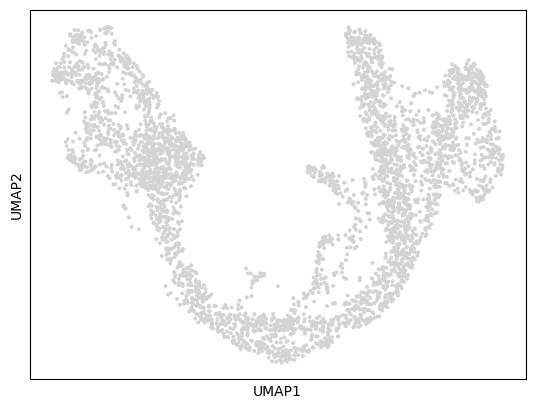

In [6]:
sc.pp.neighbors(filtered)
sc.tl.umap(filtered)
sc.pl.umap(filtered)

In [7]:
scv.pp.moments(filtered,n_neighbors=None,n_pcs=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
scv.tl.velocity(filtered)
scv.tl.velocity_graph(filtered)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/fo

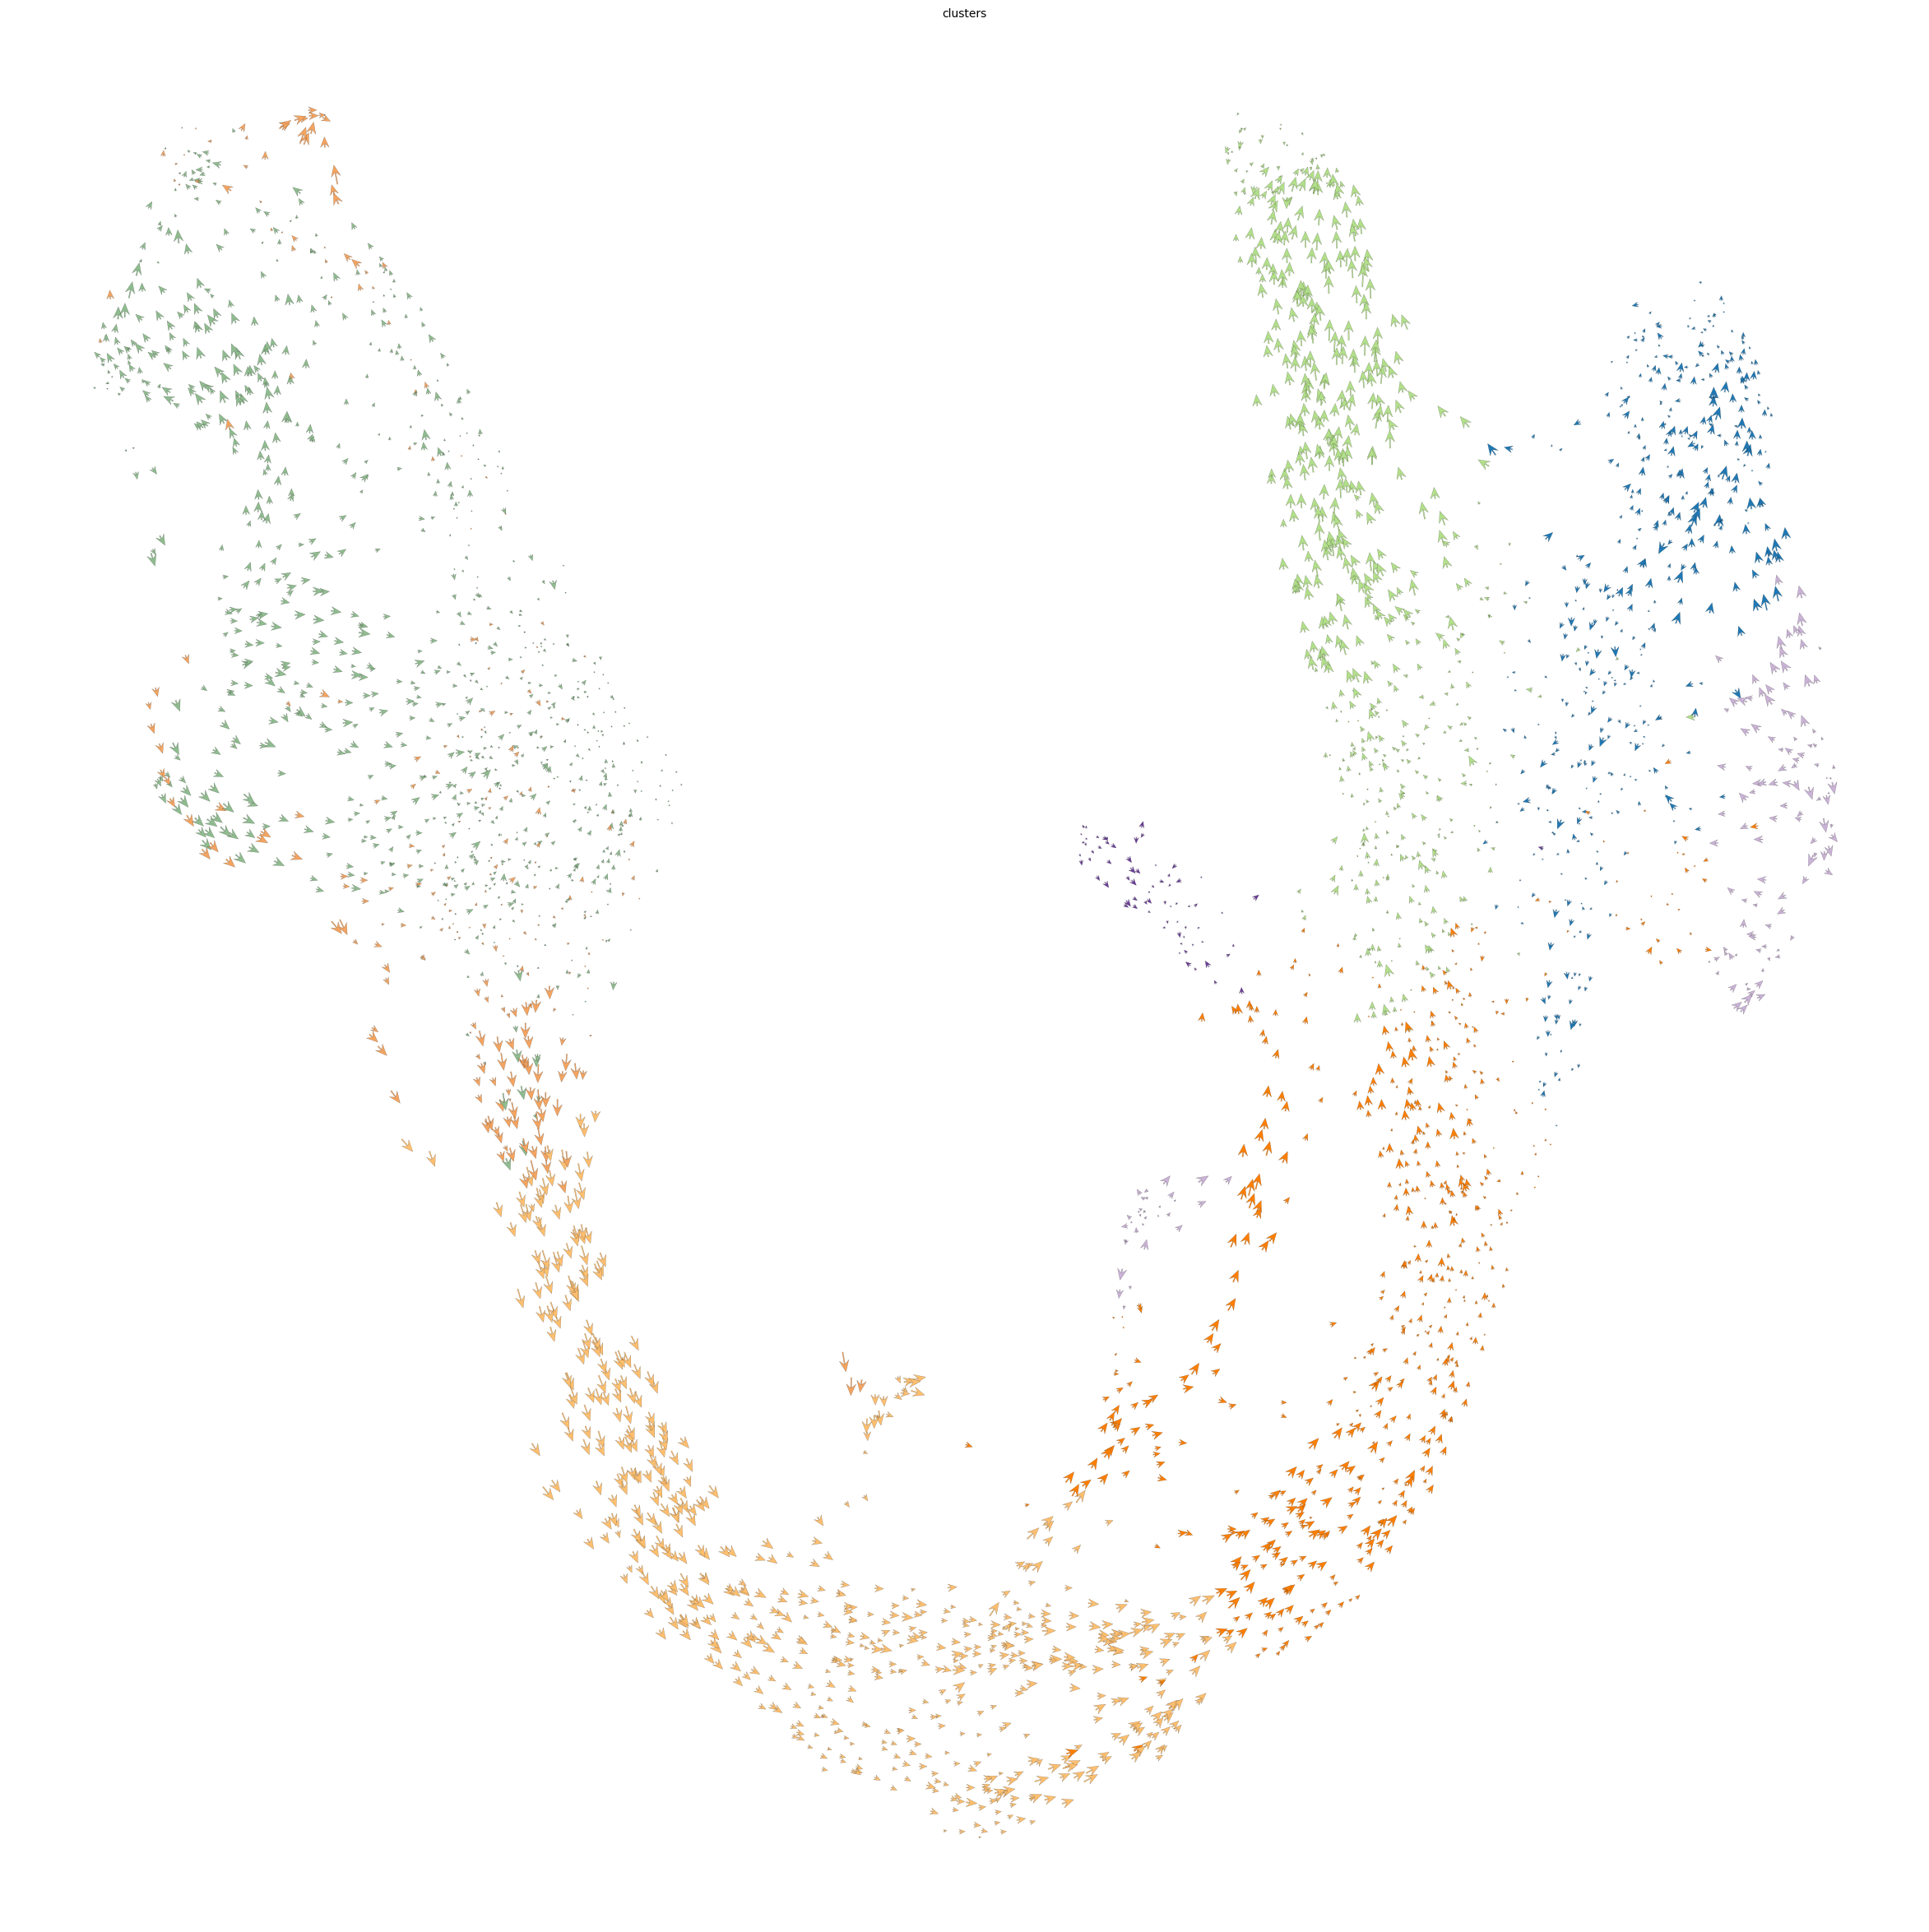

In [9]:
scv.pl.velocity_embedding(filtered,figsize=(30,30))

In [10]:
scv_raw_v = filtered.layers['velocity']

In [11]:
raw_velocity_norm = np.linalg.norm(scv_raw_v,axis=1)
filtered.obs['raw_velocity_norm'] = raw_velocity_norm

/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/fo

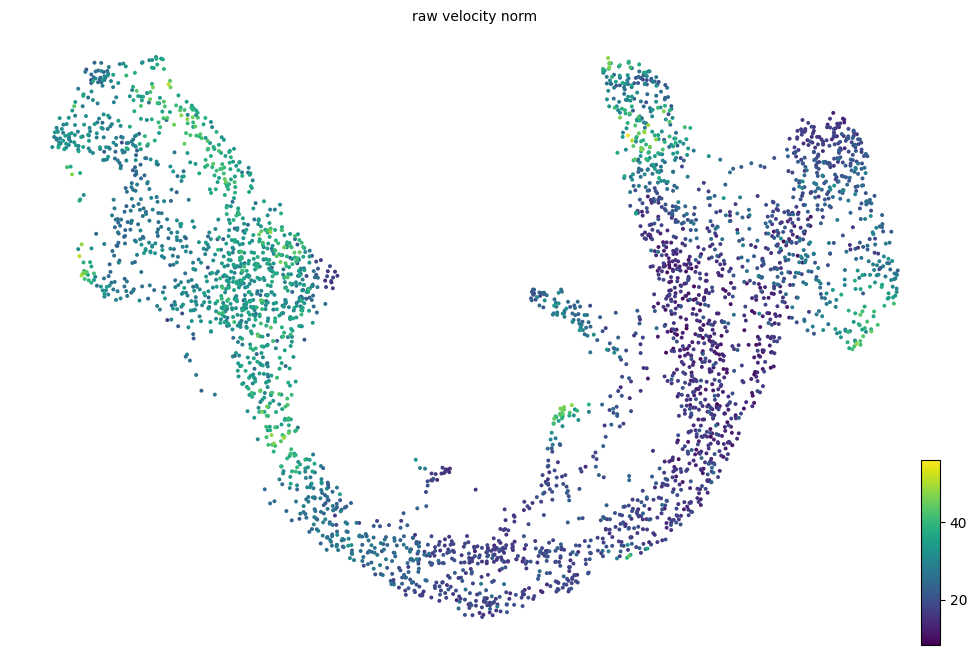

In [12]:
scv.pl.umap(filtered,color="raw_velocity_norm",figsize=(12,8))

# I don't understand the relationship between the arrow length in plot embedding umap and the raw velocity norms.
# Like... how are they getting the arrow magnitudes in plot embedding? 

In [13]:
knn = extract_knn_from_adata(filtered)

In [14]:
scv.tl.velocity_embedding(filtered,basis="umap")
scv_umap_v = filtered.obsm['velocity_umap']

scv_umap_t0 = filtered.obsm["X_umap"]
scv_umap_t1 = scv_umap_t0 + scv_umap_v

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


In [15]:
# We're going to be slightly cheeky here and get a velocity in graph space like so:

filtered.obsm["X_duplicate"] = np.array(filtered.X.todense())
scv.tl.velocity_embedding(filtered,basis="duplicate")

scv_graph_v = filtered.obsm["velocity_duplicate"]

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_duplicate', embedded velocity vectors (adata.obsm)


In [16]:
# We really want to avoid having this impact the neighbor graph, maybe I should run it off a copy?

sc.pp.pca(filtered,n_comps=50)

scv.tl.velocity_embedding(filtered,basis="pca")
scv_pca_v = filtered.obsm['velocity_pca']

scv_pca_t0 = filtered.obsm["X_pca"]
scv_pca_t1 = scv_pca_t0 + (scv_pca_v)

pca_velocity_norm = np.linalg.norm(scv_pca_v,axis=1)
filtered.obs['pca_velocity_norm'] = pca_velocity_norm



computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/fo

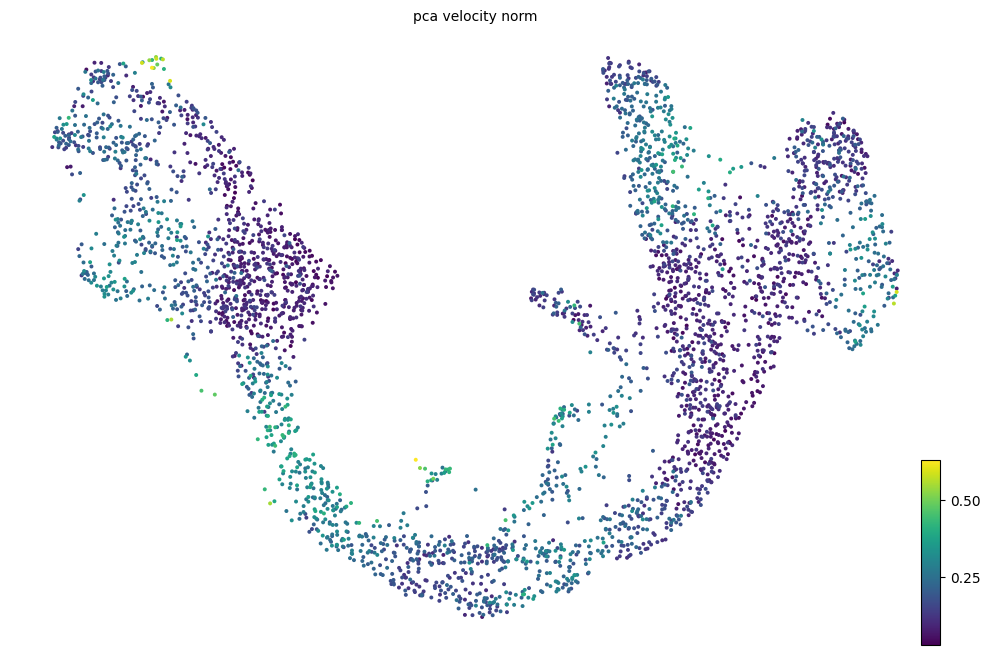

In [17]:
scv.pl.umap(filtered,color="pca_velocity_norm",figsize=(12,8))


# Check smoothness of raw vs inferred embedding

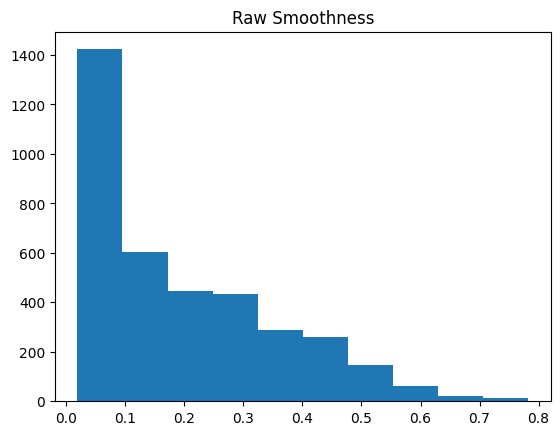

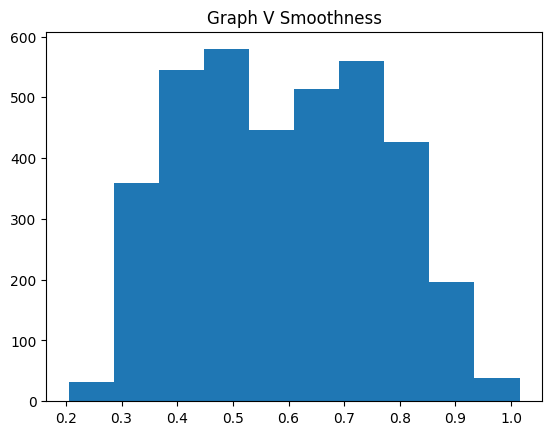

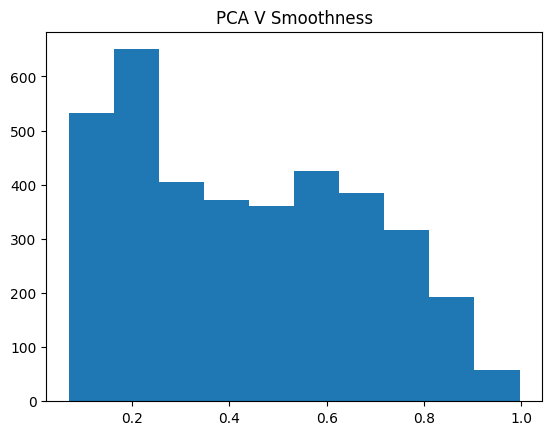

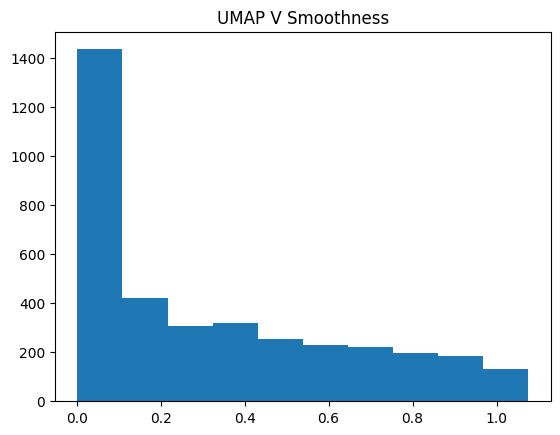

In [18]:
pca_smoothness_cosine = local_velocity_smoothness(scv_pca_v,knn,metric='cosine')
raw_smoothness_cosine = local_velocity_smoothness(scv_raw_v,knn,metric='cosine')
graph_smoothness_cosine = local_velocity_smoothness(scv_graph_v,knn,metric='cosine')
umap_smoothness_cosine = local_velocity_smoothness(scv_umap_v,knn,metric='cosine')

plt.figure()
plt.title("Raw Smoothness")
plt.hist(raw_smoothness_cosine)
plt.show()

plt.figure()
plt.title("Graph V Smoothness")
plt.hist(graph_smoothness_cosine)
plt.show()

plt.figure()
plt.title("PCA V Smoothness")
plt.hist(pca_smoothness_cosine)
plt.show()

plt.figure()
plt.title("UMAP V Smoothness")
plt.hist(umap_smoothness_cosine)
plt.show()


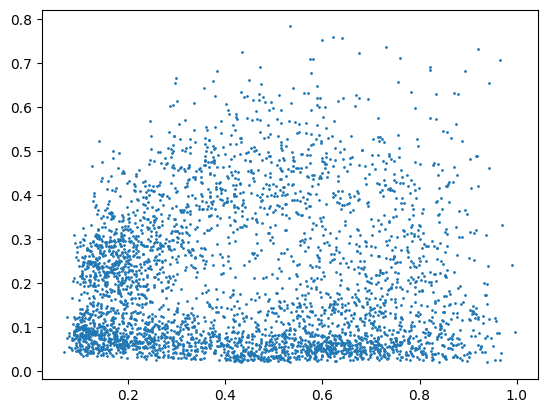

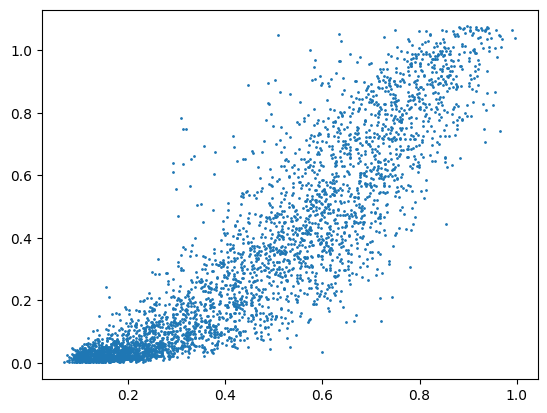

In [19]:
plt.figure()
plt.scatter(pca_smoothness_cosine,raw_smoothness_cosine,s=1)
plt.show()

plt.figure()
plt.scatter(pca_smoothness_cosine,umap_smoothness_cosine,s=1)
plt.show()

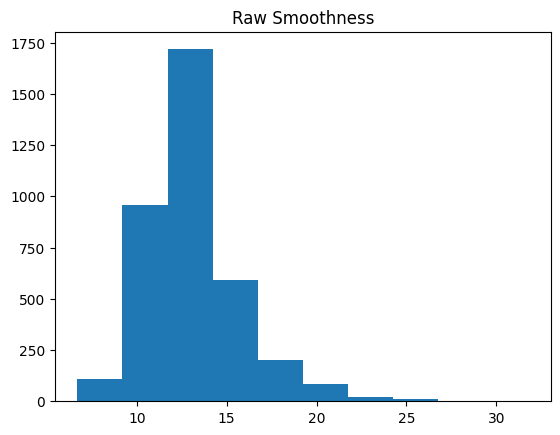

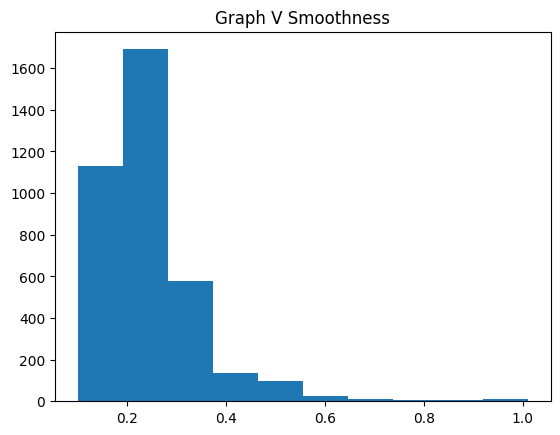

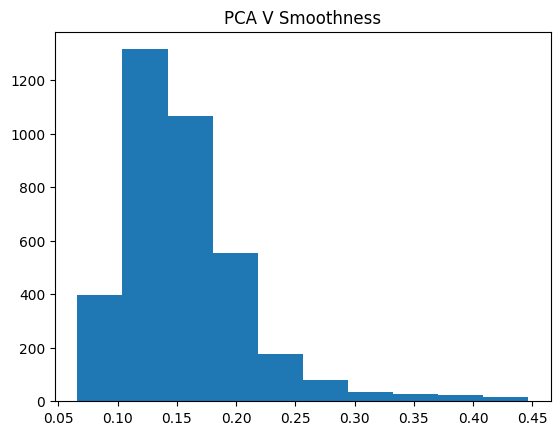

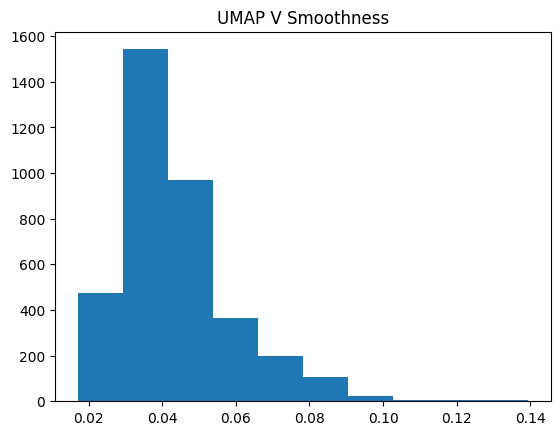

In [20]:
pca_smoothness_euclidean = local_velocity_smoothness(scv_pca_v,knn,metric='euclidean')
raw_smoothness_euclidean = local_velocity_smoothness(scv_raw_v,knn,metric='euclidean')
graph_smoothness_euclidean = local_velocity_smoothness(scv_graph_v,knn,metric='euclidean')
umap_smoothness_euclidean = local_velocity_smoothness(scv_umap_v,knn,metric='euclidean')

plt.figure()
plt.title("Raw Smoothness")
plt.hist(raw_smoothness_euclidean)
plt.show()

plt.figure()
plt.title("Graph V Smoothness")
plt.hist(graph_smoothness_euclidean)
plt.show()

plt.figure()
plt.title("PCA V Smoothness")
plt.hist(pca_smoothness_euclidean)
plt.show()

plt.figure()
plt.title("UMAP V Smoothness")
plt.hist(umap_smoothness_euclidean)
plt.show()


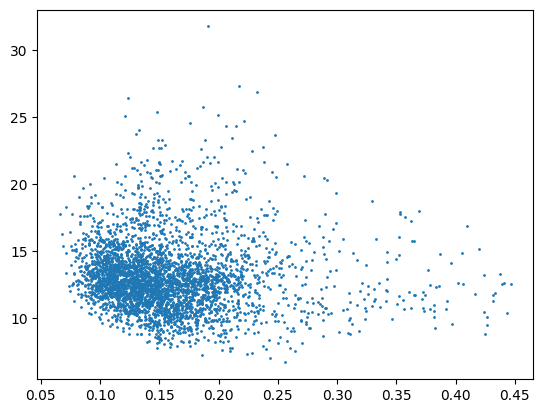

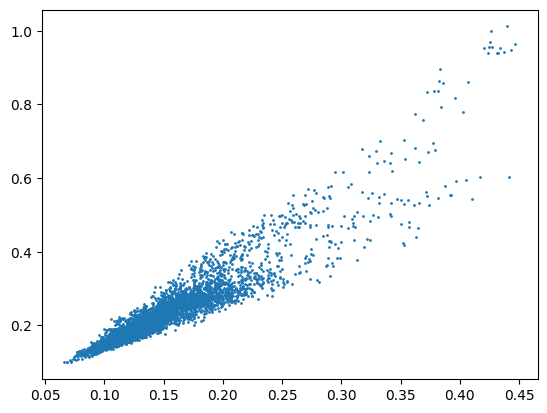

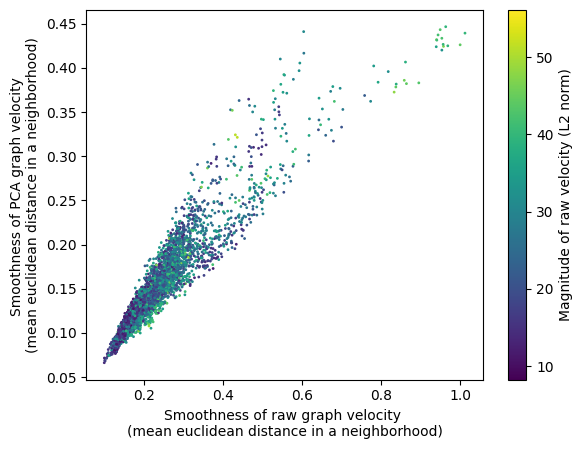

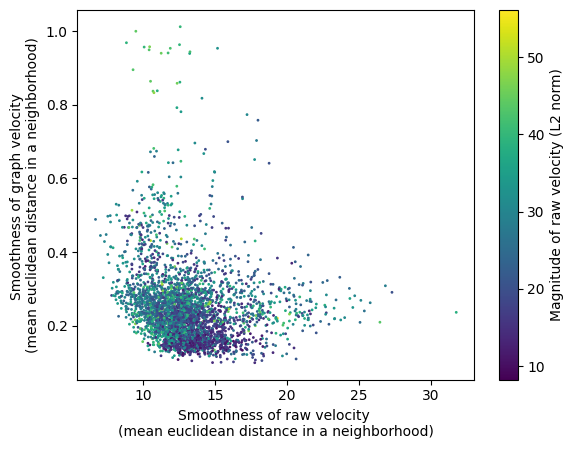

In [21]:
plt.figure()
plt.scatter(pca_smoothness_euclidean,raw_smoothness_euclidean,s=1)
plt.show()

plt.figure()
plt.scatter(pca_smoothness_euclidean,graph_smoothness_euclidean,s=1)
plt.show()


plt.figure()
plt.xlabel("Smoothness of raw graph velocity \n(mean euclidean distance in a neighborhood)")
plt.ylabel("Smoothness of PCA graph velocity \n(mean euclidean distance in a neighborhood)")
plt.scatter(graph_smoothness_euclidean,pca_smoothness_euclidean,s=1,c=raw_velocity_norm)
plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
plt.show()

plt.figure()
plt.xlabel("Smoothness of raw velocity \n(mean euclidean distance in a neighborhood)")
plt.ylabel("Smoothness of graph velocity \n(mean euclidean distance in a neighborhood)")
plt.scatter(raw_smoothness_euclidean,graph_smoothness_euclidean,s=1,c=raw_velocity_norm)
plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
plt.show()



# plt.figure()
# plt.xlabel("Smoothness of raw graph velocity \n(mean cosine distance in a neighborhood)")
# plt.ylabel("Smoothness of PCA graph velocity \n(mean cosine distance in a neighborhood)")
# plt.scatter(graph_smoothness_euclidean,pca_smoothness_cosine,s=1,c=raw_velocity_norm)
# plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
# plt.show()

# plt.figure()
# plt.xlabel("Smoothness of raw velocity \n(mean cosine distance in a neighborhood)")
# plt.ylabel("Smoothness of graph velocity \n(mean cosine distance in a neighborhood)")
# plt.scatter(raw_smoothness_euclidean,graph_smoothness_cosine,s=1,c=raw_velocity_norm)
# plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
# plt.show()

In [ ]:
# Conclusion: smoothness of raw velocity seems almost unrelated to smoothness in PCA space
# Smoothness in graph raw velocity space seems relatively well correlated to smoothness in PCA space
# This speaks poorly of the relationship between raw and graph velocity 

In [ ]:
# Need to figure out the normalization/scaling factor here. There's clearly a linear relationship but the scales are way off

In [ ]:
# Ok, so now I guess let's look at the predicted data smoothness

In [22]:
import sys

sys.path.append("/Users/bbrener1/haxx/RNAForecasterPaperCode/src/")
import python_interface as py_n

In [23]:
params = {
    "hiddenLayerNodes": 6000,
    "batchSize": 200,
    "learningRate":1e-4,
    "nEpochs":100
}

py_n.train(scv_umap_t0,scv_umap_t1,params=params)
umap_futures = py_n.predict(scv_umap_t0,params={"damping":0.7})

The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:nEpochs => 100, :useGPU => false, :hiddenLayerNodes => 6000, :batchSize => 200, :learningRate => 0.0001, :seed => 123)
Read data 2×3696 Matrix{Float32},2×3696 Matrix{Float32}
Loading Data...
Training model...
Epoch 1
Loss: 2.4992769e-5
Epoch 2
Loss: 1.6318461e-5
Epoch 3
Loss: 1.5262212e-5
Epoch 4
Loss: 1.438073e-5
Epoch 5
Loss: 1.379419e-5
Epoch 6
Loss: 1.3410235e-5
Epoch 7
Loss: 1.3168492e-5
Epoch 8
Loss: 1.3026539e-5
Epoch 9
Loss: 1.2911181e-5
Epoch 10
Loss: 1.2825009e-5
Epoch 11
Loss: 1.2766134e-5
Epoch 12
Loss: 1.2728673e-5
Epoch 13
Loss: 1.2715259e-5
Epoch 14
Loss: 1.27111125e-5
Epoch 15
Loss: 1.2709523e-5
Epoch 16
Loss: 1.2709723e-5
Epoch 17
Loss: 1.2705669e-5
Epoch 18
Loss: 1.2694012e-5
Epoch 19
Loss: 1.2674867e-5
Epoch 20
Loss: 1.2653673e-5
Epoch 21
Loss: 1.2625817e-5
Epoch 22
Loss: 1.25967035e-5
Epoch 23
Loss: 1.2565047e-5
Epoch 24
Loss: 1.2540736e-5
Epoch 25
Loss: 1.25007e-5
Epoch 2

The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 6, :useGPU => false, :batchSize => 100, :damping => 0.7f0), Dict{Symbol, Real}(:nEpochs => 100, :useGPU => false, :hiddenLayerNodes => 6000, :batchSize => 200, :learningRate => 0.0001, :seed => 123)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6


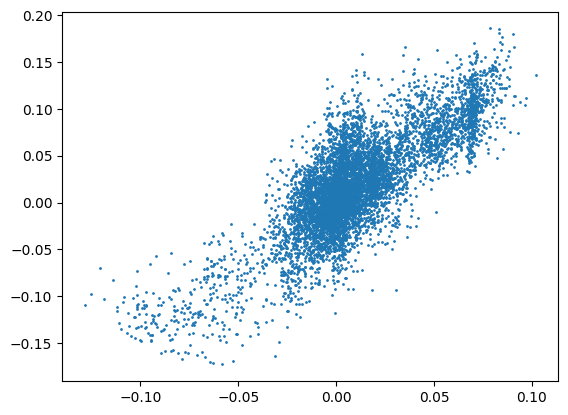

In [24]:
umap_predicted_delta = umap_futures[0] - scv_umap_t0

plt.figure()
plt.scatter(umap_predicted_delta.flatten(),scv_umap_v.flatten(),s=1)
plt.show()

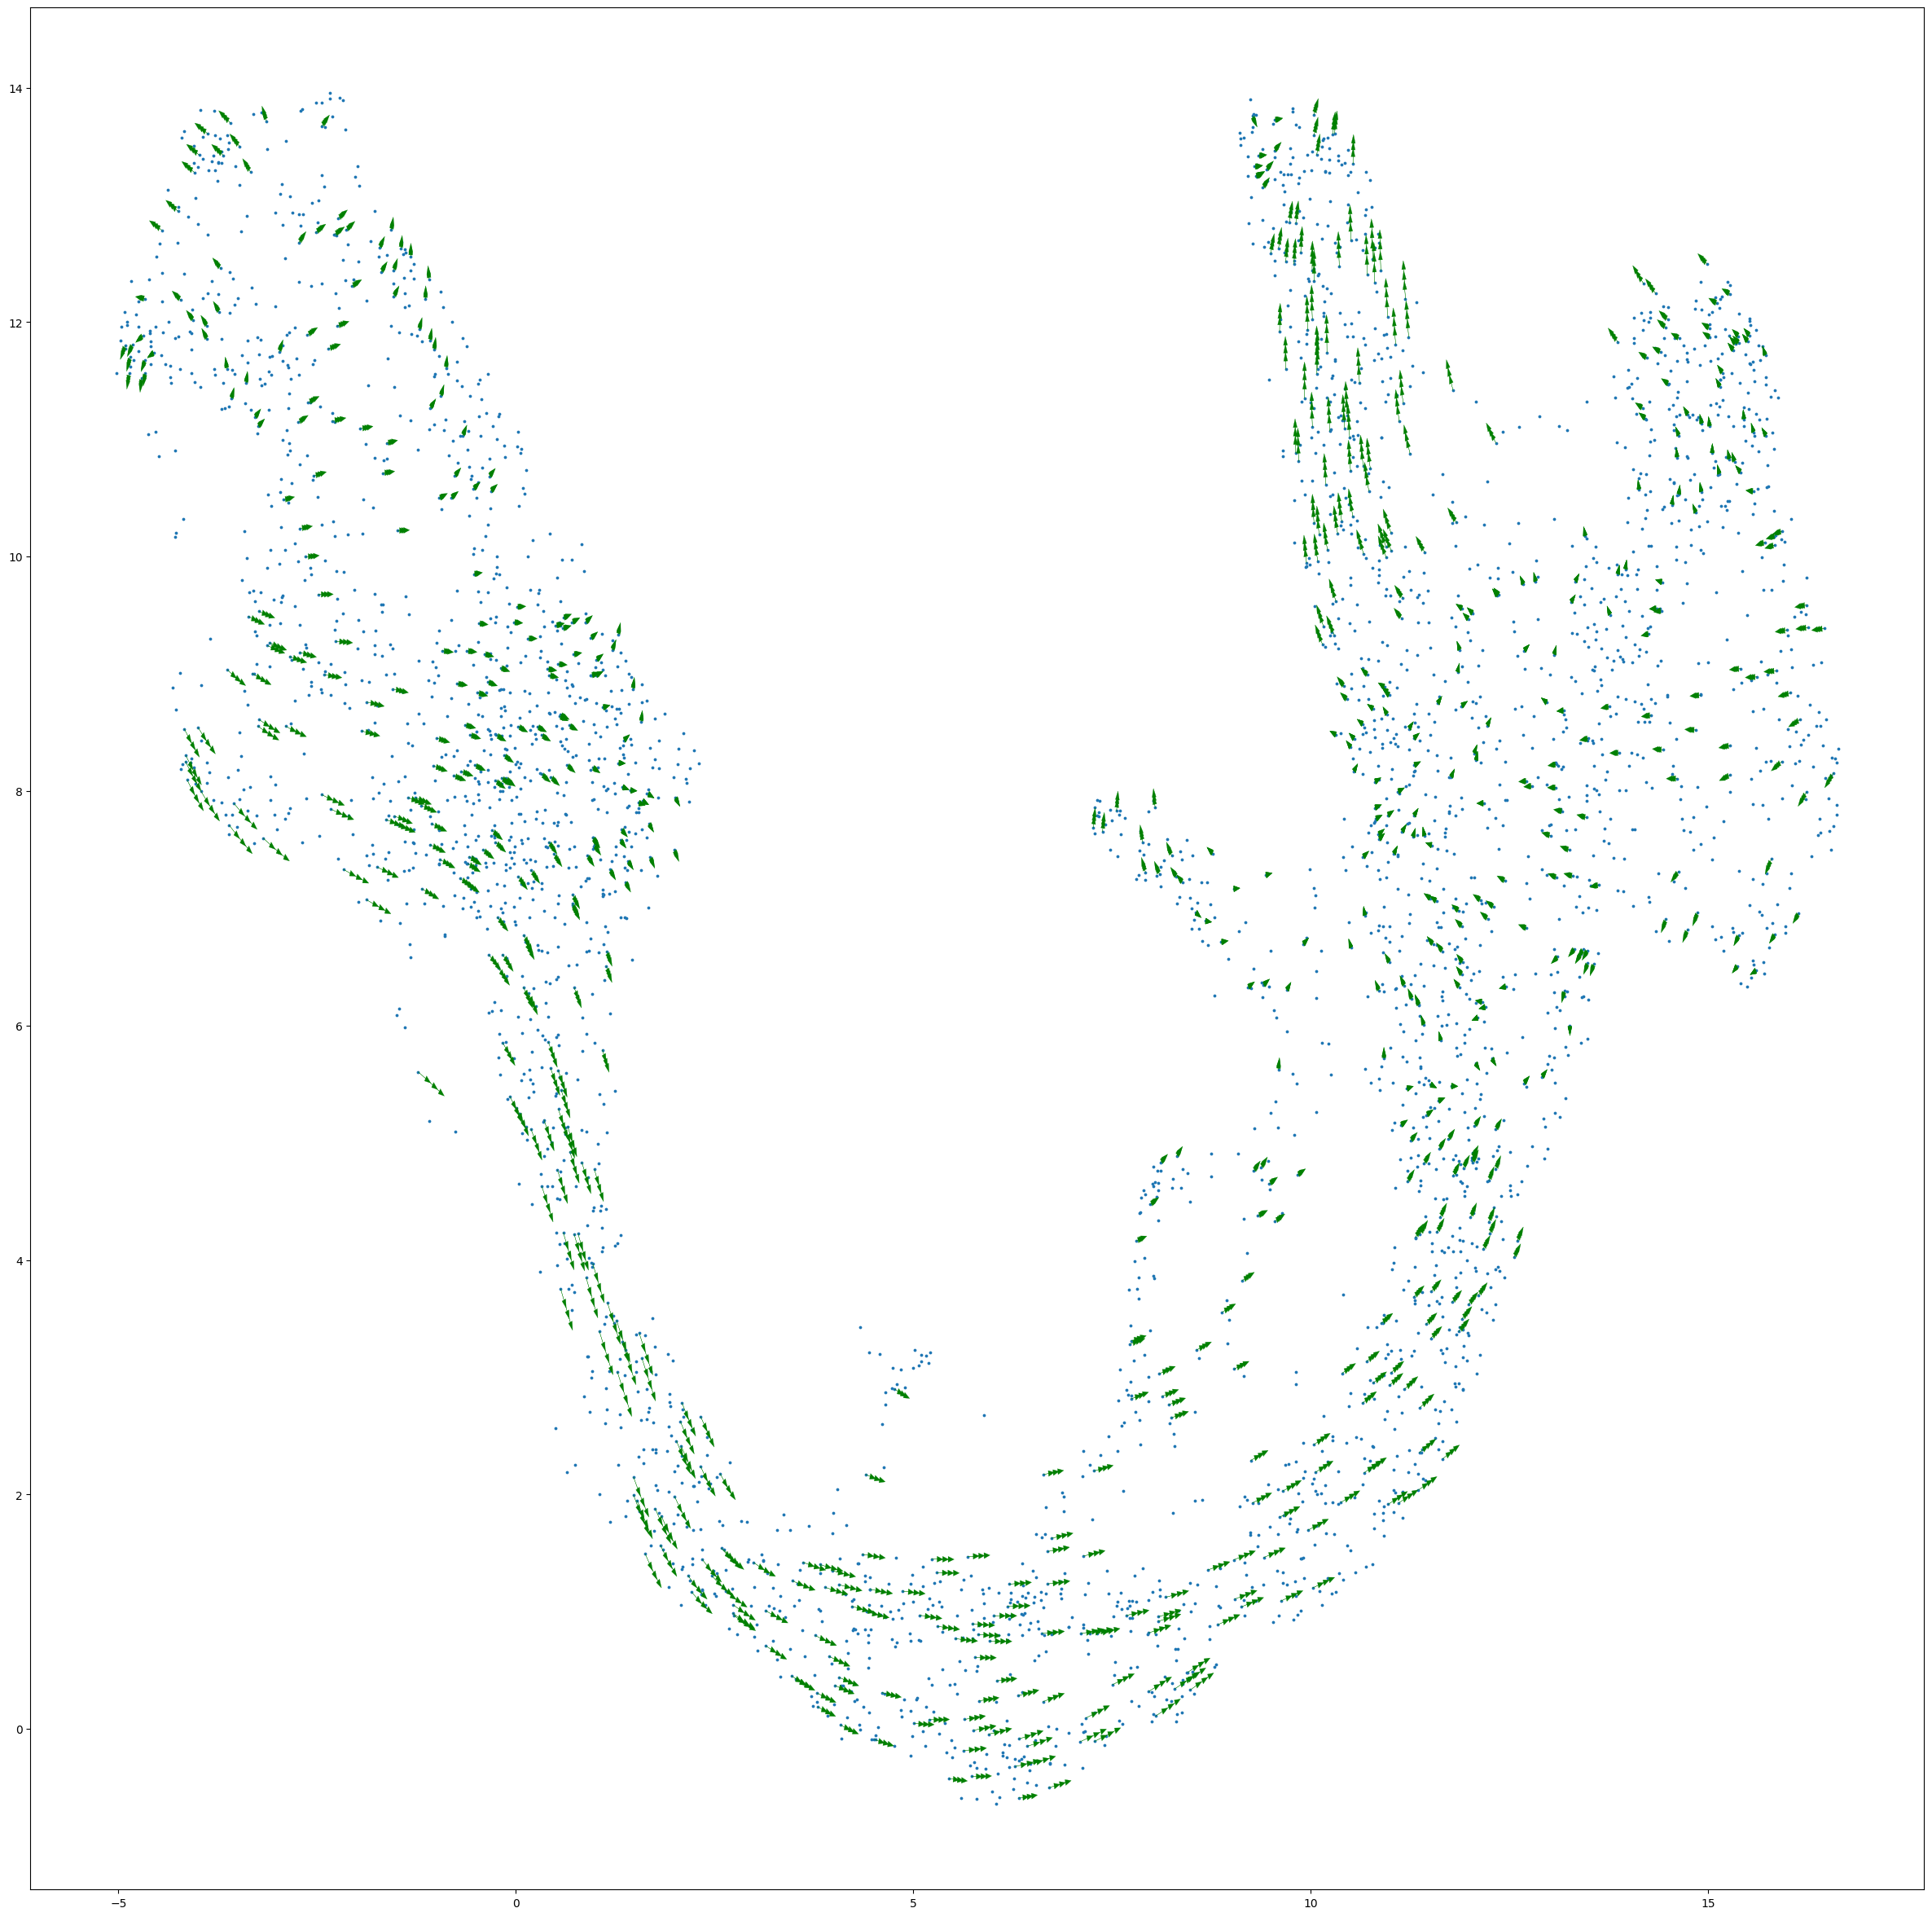

In [25]:
from velocity_scripts import trajectory_series

trajectory_series([umap_futures[0],umap_futures[1],umap_futures[2],umap_futures[3]])

In [ ]:
umap_prediction_smoothness = local_velocity_smoothness(umap_predicted_delta,knn,metric='euclidean')
umap_actual_smoothness = local_velocity_smoothness(scv_umap_v,knn,metric='euclidean')

# plt.figure()
# plt.xlabel("Smoothness of raw graph velocity \n(mean euclidean distance in a neighborhood)")
# plt.ylabel("Smoothness of umap graph velocity \n(mean euclidean distance in a neighborhood)")
# plt.scatter(graph_smoothness_euclidean,umap_prediction_smoothness,s=1,c=raw_velocity_norm)
# plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
# plt.show()

plt.figure()
plt.scatter(umap_prediction_smoothness,umap_actual_smoothness,s=1,c=raw_velocity_norm)
plt.plot([.02,.1],[.02,.1],color='red',linestyle="--")
plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
plt.xlabel("Prediction smoothness")
plt.ylabel("Actual smoothness")
plt.show()


In [26]:
# Optional re-basis

sc.pp.pca(filtered,n_comps=50)

scv.tl.velocity_embedding(filtered,basis="pca")
scv_pca_v = filtered.obsm['velocity_pca']

scv_pca_t0 = filtered.obsm["X_pca"]
scv_pca_t1 = scv_pca_t0 + (scv_pca_v)

pca_velocity_norm = np.linalg.norm(scv_pca_v,axis=1)
filtered.obs['pca_velocity_norm'] = pca_velocity_norm


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [ ]:
plt.figure()
plt.scatter(pca_velocity_norm.flatten(),raw_velocity_norm.flatten(),s=1)
plt.show()

In [32]:
# # PCA prediction

params = {
    "hiddenLayerNodes": 50,
    "batchSize": 200,
    "learningRate":1e-4,
    "nEpochs":3000
}

py_n.train(scv_pca_t0,scv_pca_t1,params=params)

pca_futures = py_n.predict(scv_pca_t0,params={"damping":0.7,"tSteps":20})

pca_futures.shape

The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:nEpochs => 3000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :seed => 123)
Read data 50×3696 Matrix{Float32},50×3696 Matrix{Float32}
Loading Data...
Training model...
Epoch 1
Loss: 0.009741867
Epoch 2
Loss: 0.00816626
Epoch 3
Loss: 0.007048986
Epoch 4
Loss: 0.006204569
Epoch 5
Loss: 0.0055370834
Epoch 6
Loss: 0.004992564
Epoch 7
Loss: 0.004537869
Epoch 8
Loss: 0.0041511157
Epoch 9
Loss: 0.0038172426
Epoch 10
Loss: 0.0035255654
Epoch 11
Loss: 0.0032682049
Epoch 12
Loss: 0.0030392804
Epoch 13
Loss: 0.0028343427
Epoch 14
Loss: 0.0026499622
Epoch 15
Loss: 0.0024832438
Epoch 16
Loss: 0.0023319894
Epoch 17
Loss: 0.0021943846
Epoch 18
Loss: 0.0020688572
Epoch 19
Loss: 0.0019540156
Epoch 20
Loss: 0.0018487354
Epoch 21
Loss: 0.0017521245
Epoch 22
Loss: 0.0016633299
Epoch 23
Loss: 0.0015816053
Epoch 24
Loss: 0.0015062956
Epoch 25
Loss: 0.0014368024
Epoch 26
Lo

The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 20, :useGPU => false, :batchSize => 100, :damping => 0.7f0), Dict{Symbol, Real}(:nEpochs => 3000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :seed => 123)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Predicting step 7
Predicting step 8
Predicting step 9
Predicting step 10
Predicting step 11
Predicting step 12
Predicting step 13
Predicting step 14
Predicting step 15
Predicting step 16
Predicting step 17
Predicting step 18
Predicting step 19
Predicting step 20
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6
Writing timepoint 7
Writing timepoint 8
Writing timepoint 9
Writing timepoint 10
Writing timepoint 11
Writing timepoint 12
Writing timepoint 13
Writing timepoint 14
Writing timepoint 15
Writing timepoint 1

(20, 3696, 50)

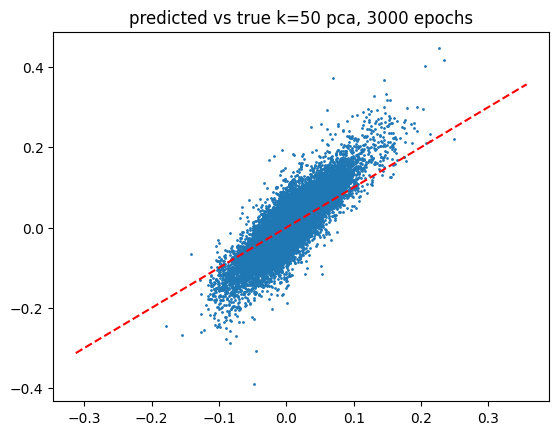

In [43]:
pca_predicted_delta = pca_futures[0] - scv_pca_t0

plt.figure()
plt.title("predicted vs true k=50 pca, 3000 epochs")
plt.scatter(pca_predicted_delta.flatten(),scv_pca_v.flatten(),s=1)
axlim_min = min(min(pca_predicted_delta.flatten()),min(scv_pca_v.flatten())) * .8
axlim_max = max(max(pca_predicted_delta.flatten()),max(scv_pca_v.flatten())) * .8
plt.plot([axlim_min,axlim_max],[axlim_min,axlim_max],color='red',linestyle="--")
plt.show()

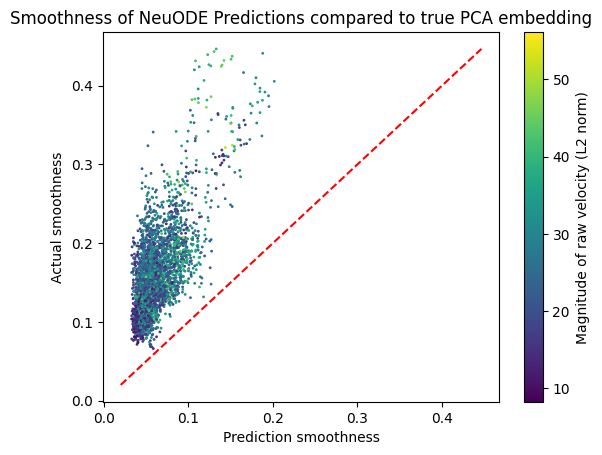

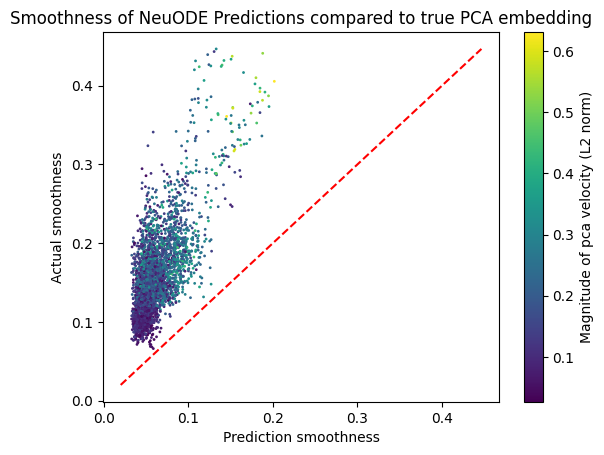

In [35]:
pca_prediction_smoothness = local_velocity_smoothness(pca_predicted_delta,knn,metric='euclidean')
pca_actual_smoothness = local_velocity_smoothness(scv_pca_v,knn,metric='euclidean')

plt.figure()
plt.title("Smoothness of NeuODE Predictions compared to true PCA embedding")
plt.scatter(pca_prediction_smoothness,pca_actual_smoothness,s=1,c=raw_velocity_norm)
axlim = max(max(pca_prediction_smoothness),max(pca_actual_smoothness))
plt.plot([.02,axlim],[.02,axlim],color='red',linestyle="--")
plt.colorbar(label="Magnitude of raw velocity (L2 norm)")
plt.xlabel("Prediction smoothness")
plt.ylabel("Actual smoothness")
plt.show()

plt.figure()
plt.title("Smoothness of NeuODE Predictions compared to true PCA embedding")
plt.scatter(pca_prediction_smoothness,pca_actual_smoothness,s=1,c=pca_velocity_norm)
axlim = max(max(pca_prediction_smoothness),max(pca_actual_smoothness))
plt.plot([.02,axlim],[.02,axlim],color='red',linestyle="--")
plt.colorbar(label="Magnitude of pca velocity (L2 norm)")
plt.xlabel("Prediction smoothness")
plt.ylabel("Actual smoothness")
plt.show()


In [ ]:
# Does the better PCA future embed any more gracefully? 

In [36]:
from velocity_scripts import umap_velocity_via_joint,trajectory_series,umap_trajectory_joint

In [47]:
pca_umap_t0,pca_umap_t1,pca_umap_v = umap_velocity_via_joint(scv_pca_t0,pca_futures[0])

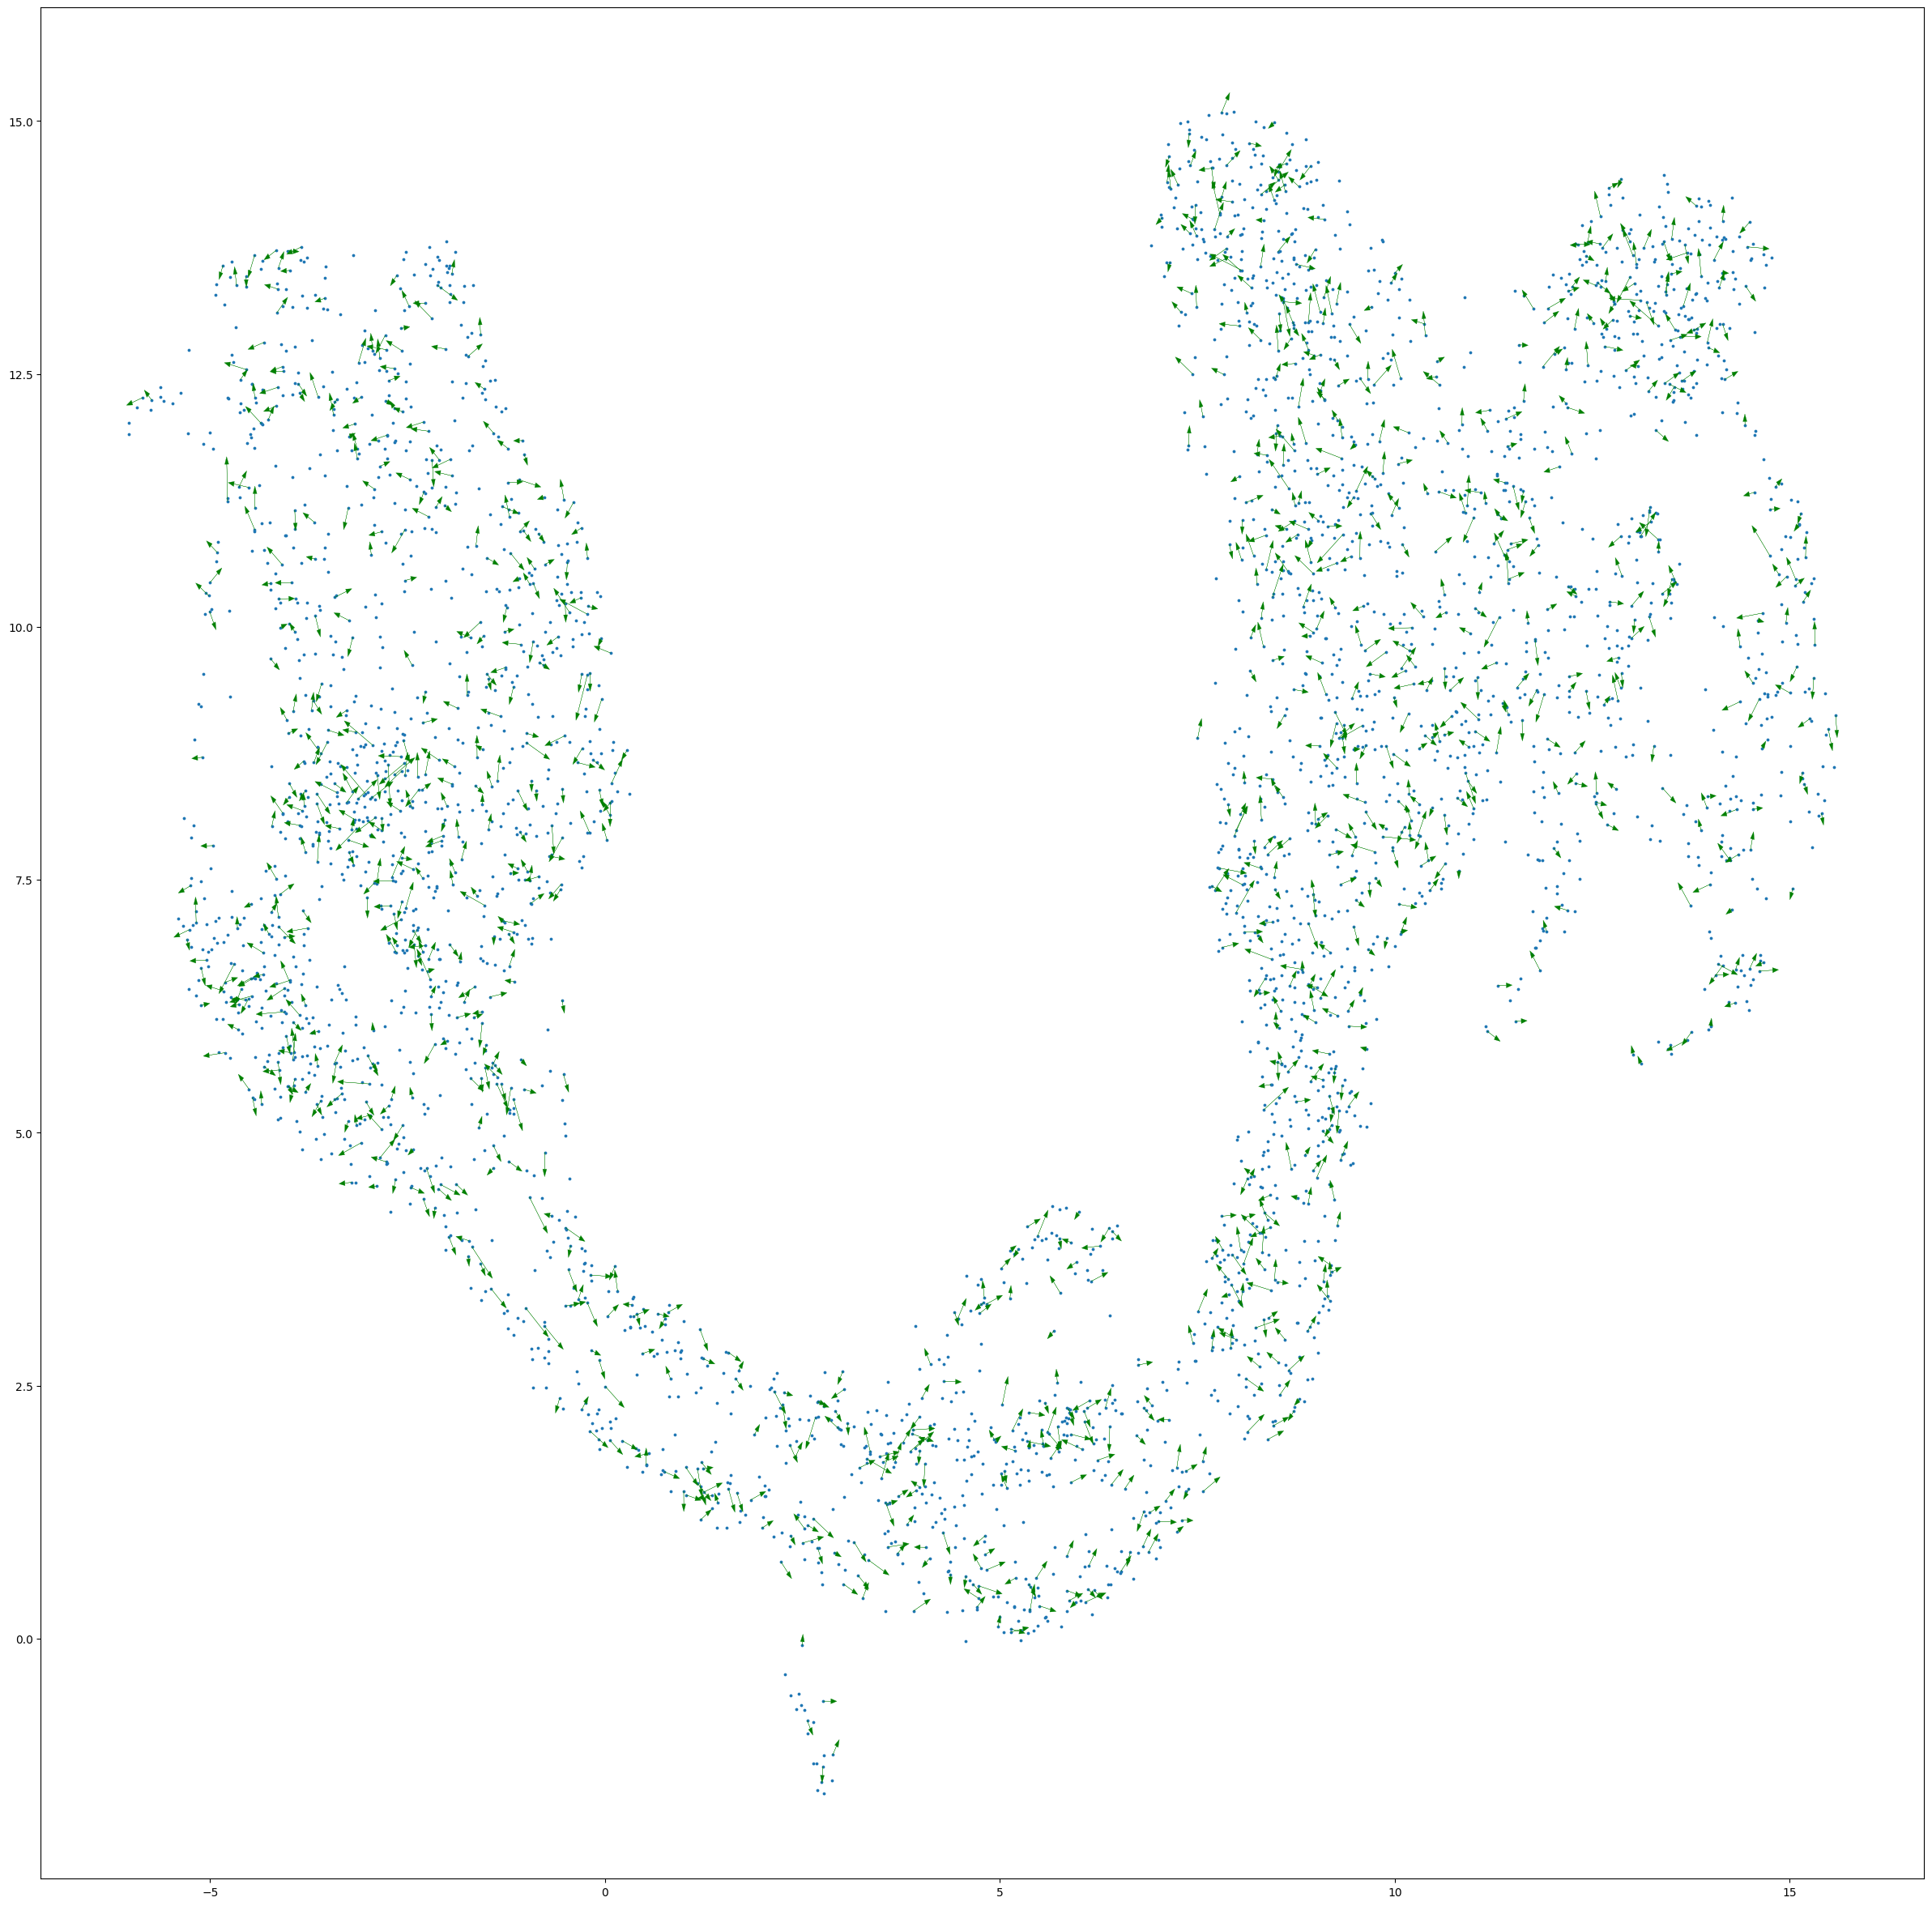

In [48]:
trajectory_series([pca_umap_t0,pca_umap_t1],frequency=3)

In [ ]:

def umap_trajectory_joint(timepoints):
    if len(timepoints) > 100:
        raise Exception(f"You want timepoints in a list, I think you might have passed a matrix, primary dimension is {len(timepoints)}")
    stacked = np.vstack(timepoints)
    
    umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
    u_t_joint = umap_model.fit_transform(stacked)
    
    running_totals = np.cumsum([t.shape[0] for t in timepoints])
    running_totals = [0,] + list(running_totals)
    embedded_timepoints = [u_t_joint[beginning:end] for beginning,end in zip(running_totals[:-1],running_totals[1:])]
    
    return embedded_timepoints


In [ ]:
umap_trajectories = umap_trajectory_joint([scv_pca_t0,pca_futures[10],pca_futures[19]])

In [ ]:
from umap import UMAP

In [ ]:
trajectory_series(umap_trajectories)

In [ ]:
umap_trajectories